In [268]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Data Preprocessing

In [269]:
# Read CSV file
r = pd.read_csv('IMDB_reviews.csv')

In [270]:
r.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Cleaning Data

In [271]:
# Pre-cleaned data
print(r['review'][5])

Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother's slow awakening to what's happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they'd all be "up" for this movie.


In [272]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from nltk.test.gensim_fixt import setup_module
setup_module()
import gensim
import nltk.tokenize

### Stop words and stemming

In [273]:
# Stop words will remove filler words
# Stemmer removes word endings
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [274]:
f_ = lambda x: ' '.join([stemmer.stem(word) for word in x.split() 
                             if word not in (sw)])

In [275]:
r['review'] = r['review'].apply(f_)

In [276]:
# After removing stop words and stemming
print(r['review'][5])

probabl all-tim favorit movie, stori selflessness, sacrific dedic nobl cause, preachi boring. it never get old, despit seen 15 time last 25 years. paul luka perform bring tear eyes, bett davis, one truli sympathet roles, delight. the kid are, grandma says, like "dressed-up midgets" children, make fun watch. and mother slow awaken what happen world roof believ startling. if i dozen thumbs, they'd "up" movie.


### Extracting words

In [277]:
def clean_text(data):
    # Make all words lowercase
    data = data.lower()
    
    # Remove line breaks
    data = data.replace("<br /><br />", "")
    
    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    return data

In [278]:
temp = []
# Turning the pandas dataframe "Series" to a list
data_to_list = r['review'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean_text(data_to_list[i]))

In [279]:
# After partially cleaning
list(temp[:1])

['one review mention watch 1 oz episod hooked. they right, exact happen me.the first thing struck oz brutal unflinch scene violence, set right word go. trust me, show faint heart timid. this show pull punch regard drugs, sex violence. it hardcore, classic use word.it call oz nicknam given oswald maximum secur state penitentary. it focus main emerald city, experiment section prison cell glass front face inwards, privaci high agenda. em citi home many..aryans, muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgi deal shadi agreement never far away.i would say main appeal show due fact goe show dare. forget pretti pictur paint mainstream audiences, forget charm, forget romance...oz mess around. the first episod i ever saw struck nasti surreal, i say i readi it, i watch more, i develop tast oz, got accustom high level graphic violence. not violence, injustic (crook guard wholl sold nickel, inmat wholl kill order get away it, well mannered, middl 

In [280]:
# Remove repeating words from dataset and punctuation
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [281]:
data_words = list(sentence_to_words(temp))

In [283]:
def detokenize(text):
    return nltk.tokenize.treebank.TreebankWordDetokenizer().detokenize(text)

In [284]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))

In [285]:
# After fully cleaning data
print(data[5])

probabl all tim favorit movie stori selflessness sacrific dedic nobl cause preachi boring it never get old despit seen time last years paul luka perform bring tear eyes bett davis one truli sympathet roles delight the kid are grandma says like dressed up midgets children make fun watch and mother slow awaken what happen world roof believ startling if dozen thumbs theyd up movie


In [286]:
# Turn data to numpy array
data = np.array(data)

## Label Encoding

In [287]:
from sklearn.preprocessing import LabelEncoder

### Encoding the output

In [288]:
y = r['sentiment'].values

In [289]:
print(y)

['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [290]:
le = LabelEncoder()
y = le.fit_transform(y)

In [291]:
print(y)

[1 1 1 ... 0 0 0]


## Data splitting

In [292]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

### Converting text data to 3D float data

In [293]:
max_words = 5000
max_len = 200

# Tokenizing (breaking down text into sequences of integers)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
reviews = pad_sequences(sequences, maxlen=max_len)

In [294]:
print(reviews)

[[   0    0    0 ...  527 3612  424]
 [   0    0    0 ...  444   20  150]
 [   0    0    0 ...   30   12  992]
 ...
 [   0    0    0 ...  306  458 3493]
 [   0    0    0 ... 1859  358  539]
 [   0    0    0 ...  974  604   15]]


### Splitting data

In [295]:
X_train, X_test, y_train, y_test = train_test_split(reviews, y, random_state=0)

# Building the model

In [367]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.optimizers import RMSprop,Adam
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [368]:
model = Sequential([
    Embedding(max_words, 40, input_length=max_len),
    Bidirectional(LSTM(20, dropout=0.5)),
    Dense(1, activation="sigmoid"),
])

In [369]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 200, 40)           200000    
                                                                 
 bidirectional_22 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 1)                 41        
                                                                 
Total params: 209,801
Trainable params: 209,801
Non-trainable params: 0
_________________________________________________________________


In [370]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [371]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
293/293 [==============================] - 89s 293ms/step - loss: 0.4275 - accuracy: 0.8072 - val_loss: 0.3053 - val_accuracy: 0.8763
Epoch 2/10
293/293 [==============================] - 89s 303ms/step - loss: 0.2745 - accuracy: 0.8911 - val_loss: 0.2905 - val_accuracy: 0.8826
Epoch 3/10
293/293 [==============================] - 106s 362ms/step - loss: 0.2437 - accuracy: 0.9067 - val_loss: 0.2977 - val_accuracy: 0.8808
Epoch 4/10
293/293 [==============================] - 64s 219ms/step - loss: 0.2254 - accuracy: 0.9118 - val_loss: 0.2976 - val_accuracy: 0.8791


In [372]:
score = model.evaluate(X_test, y_test)

391/391 [==============================] - 7s 18ms/step - loss: 0.2905 - accuracy: 0.8826


# Model evaluation

## Confusion matrix

In [373]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [374]:
y_pred = model.predict(X_test)

391/391 [==============================] - 9s 22ms/step


In [375]:
print(y_pred[:3])

[[0.9720635 ]
 [0.01517473]
 [0.9693295 ]]


In [376]:
for i in range(len(y_pred)):
    if y_pred[i] > 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

In [377]:
print(y_pred[:3])

[[1.]
 [0.]
 [1.]]


In [379]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm)

Confusion Matrix: [[5513  778]
 [ 689 5520]]


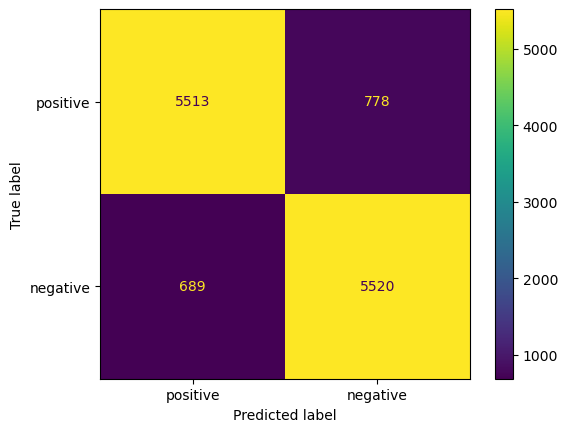

In [380]:
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ("positive", "negative"))
display.plot()
plt.show()